# Transfer Learning with VGG16

VGG16 net for the skin cancer dataset.

In [1]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 4060 Laptop GPU is available.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import torch
# Create a tensor on the CPU
tensor = torch.randn((3, 3))
#Move the tensor to the GPU
tensor = tensor.to('cuda')

In [4]:
import torch
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [5]:
# check gpu availability
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
# check gpu availability
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load in the Dataset

In [1]:
import pandas as pd

# Load the training metadata and ground truth CSV files
train_metadata = pd.read_csv('Dataset/ISIC_2019_Training_Metadata.csv')
train_groundtruth = pd.read_csv('Dataset/ISIC_2019_Training_GroundTruth.csv')

In [2]:
# Display first few rows of each DataFrame
print("Training Metadata:")
print(train_metadata.head())

print("\nTraining GroundTruth:")
print(train_groundtruth.head())

Training Metadata:
          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male

Training GroundTruth:
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [3]:
# Merge metadata with ground truth on the 'image' column
train_data = pd.merge(train_metadata, train_groundtruth, on='image')

# Display first few rows of the merged DataFrame
print("\nMerged Training Data:")
print(train_data.head())



Merged Training Data:
          image  age_approx anatom_site_general lesion_id     sex  MEL   NV  \
0  ISIC_0000000        55.0      anterior torso       NaN  female  0.0  1.0   
1  ISIC_0000001        30.0      anterior torso       NaN  female  0.0  1.0   
2  ISIC_0000002        60.0     upper extremity       NaN  female  1.0  0.0   
3  ISIC_0000003        30.0     upper extremity       NaN    male  0.0  1.0   
4  ISIC_0000004        80.0     posterior torso       NaN    male  1.0  0.0   

   BCC   AK  BKL   DF  VASC  SCC  UNK  
0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0   0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0   0.0  0.0  0.0  


In [4]:
# Display the shape of the merged DataFrame
print(f"Shape of the merged DataFrame: {train_data.shape}")

Shape of the merged DataFrame: (25331, 14)


## Preprocess the Dataset

In [5]:
# Apply necessary transformations and augmentations
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
#from keras.applications import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os

# Define the paths to the images
train_images_dir = 'Dataset/ISIC_2019_Training_Input'
test_images_dir = 'Dataset/ISIC_2019_Test_Input'

# Ensure the image filenames have the correct format (append .jpg if necessary)
train_data['image'] = train_data['image'].apply(lambda x: x + '.jpg')

# Create the full path for each image
train_data['image_path'] = train_data['image'].apply(lambda x: os.path.join(train_images_dir, x))

# Split the data into training and validation sets
train_df, val_df = train_test_split(train_data, test_size=0.2, stratify=train_data[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']])

# ImageDataGenerator for training and validation with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create the training and validation generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,    
    directory=None,  # Images are already included in image_path column
    x_col='image_path',
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(224, 224),  # Resize images to match VGG16 input size
    batch_size=32,
    class_mode='raw',  # For multi-output regression/classification
    shuffle=True
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,  # Images are already included in image_path column
    x_col='image_path',
    y_col=['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC'],
    target_size=(224, 224),  # Resize images to match VGG16 input size
    batch_size=32,
    class_mode='raw',  # For multi-output regression/classification
    shuffle=False
)


Found 20264 validated image filenames.
Found 5067 validated image filenames.


In [6]:
print(f"Training samples: {train_generator.n}")
print(f"Validation samples: {validation_generator.n}")

print(f"Training steps per epoch: {len(train_generator)}")
print(f"Validation steps: {len(validation_generator)}")


Training samples: 20264
Validation samples: 5067
Training steps per epoch: 634
Validation steps: 159


In [7]:
x_batch, y_batch = next(train_generator)
print(f"x_batch shape: {x_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")

x_batch shape: (32, 224, 224, 3)
y_batch shape: (32, 8)


In [10]:
from tensorflow import keras
from keras.applications import VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np
import sys
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from PIL import ImageFile

# use gpu for training
import tensorflow as tf
from tensorflow.python.client import device_lib

# Load the VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)  # 8 classes output

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),  # Use 'learning_rate' instead of 'lr'
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Train the model with callbacks
history = model.fit(
    train_generator,
    epochs=50,  # Set a higher number to allow for early stopping
    validation_data=validation_generator,
    #class_weight=class_weights_dict,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/50
634/634 [==============================] - 232s 366ms/step - loss: 1.5057 - accuracy: 0.4911 - val_loss: 1.2743 - val_accuracy: 0.5542
Epoch 2/50
634/634 [==============================] - 212s 334ms/step - loss: 1.3628 - accuracy: 0.5355 - val_loss: 1.2227 - val_accuracy: 0.5832
Epoch 3/50
634/634 [==============================] - 217s 342ms/step - loss: 1.3160 - accuracy: 0.5553 - val_loss: 1.1896 - val_accuracy: 0.5899
Epoch 4/50
634/634 [==============================] - 214s 338ms/step - loss: 1.2816 - accuracy: 0.5643 - val_loss: 1.1613 - val_accuracy: 0.5962
Epoch 5/50
634/634 [==============================] - 211s 333ms/step - loss: 1.2572 - accuracy: 0.5674 - val_loss: 1.1459 - val_accuracy: 0.5956
Epoch 6/50
634/634 [==============================] - 208s 328ms/step - loss: 1.2418 - accuracy: 0.5722 - val_loss: 1.1309 - val_accuracy: 0.6033
Epoch 7/50
634/634 [==============================] - 209s 330ms/step - loss: 1.2253 - accuracy: 0.5803 - val_loss: 1.1177 -

In [11]:
# Display the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [12]:
# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(validation_generator, steps=len(validation_generator))
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

159/159 [==============================] - 24s 148ms/step - loss: 0.9723 - accuracy: 0.6517
Validation Loss: 0.9723
Validation Accuracy: 0.6517


In [13]:
# Display the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

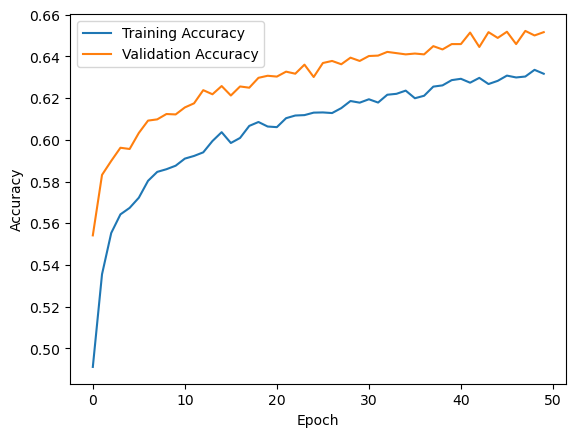

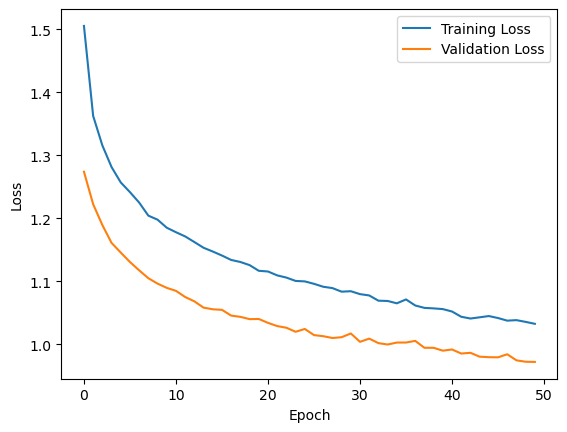

In [14]:
# visualize the training process
import matplotlib.pyplot as plt 

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
# Save the trained model
model.save('multi_class_skin_lesion_classifier_vgg16.keras')

## Testing

In [25]:
# test the model on the test set (i dont have test ground truth) 
# Load the test metadata CSV file
test_metadata = pd.read_csv('Dataset/ISIC_2019_Test_Metadata.csv')

# Ensure the image filenames have the correct format (append .jpg if necessary)
test_metadata['image'] = test_metadata['image'].apply(lambda x: x + '.jpg')

# Create the full path for each image
test_metadata['image_path'] = test_metadata['image'].apply(lambda x: os.path.join(test_images_dir, x))

# Display the first few rows of the test metadata
print(test_metadata.head())

              image  age_approx anatom_site_general     sex  \
0  ISIC_0034321.jpg        60.0                 NaN  female   
1  ISIC_0034322.jpg        70.0      anterior torso    male   
2  ISIC_0034323.jpg        70.0     lower extremity    male   
3  ISIC_0034324.jpg        70.0     lower extremity    male   
4  ISIC_0034325.jpg        30.0     upper extremity  female   

                                      image_path  
0  Dataset/ISIC_2019_Test_Input\ISIC_0034321.jpg  
1  Dataset/ISIC_2019_Test_Input\ISIC_0034322.jpg  
2  Dataset/ISIC_2019_Test_Input\ISIC_0034323.jpg  
3  Dataset/ISIC_2019_Test_Input\ISIC_0034324.jpg  
4  Dataset/ISIC_2019_Test_Input\ISIC_0034325.jpg  


In [26]:
# Create the test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_metadata,
    directory=None,  # Images are already included in image_path column
    x_col='image_path',
    target_size=(224, 224),  # Resize images to match VGG16 input size
    batch_size=32,
    class_mode=None,  # For testing, we don't need labels
    shuffle=False
)


Found 8238 validated image filenames.


In [27]:
# Load the trained model
model = keras.models.load_model('multi_class_skin_lesion_classifier_vgg16.keras')

# Predict the test data
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)


258/258 [==============================] - 51s 196ms/step


In [28]:
# Get the predicted class labels
predicted_labels = np.argmax(predictions, axis=1) 
print(predicted_labels)

[1 1 4 ... 1 2 2]


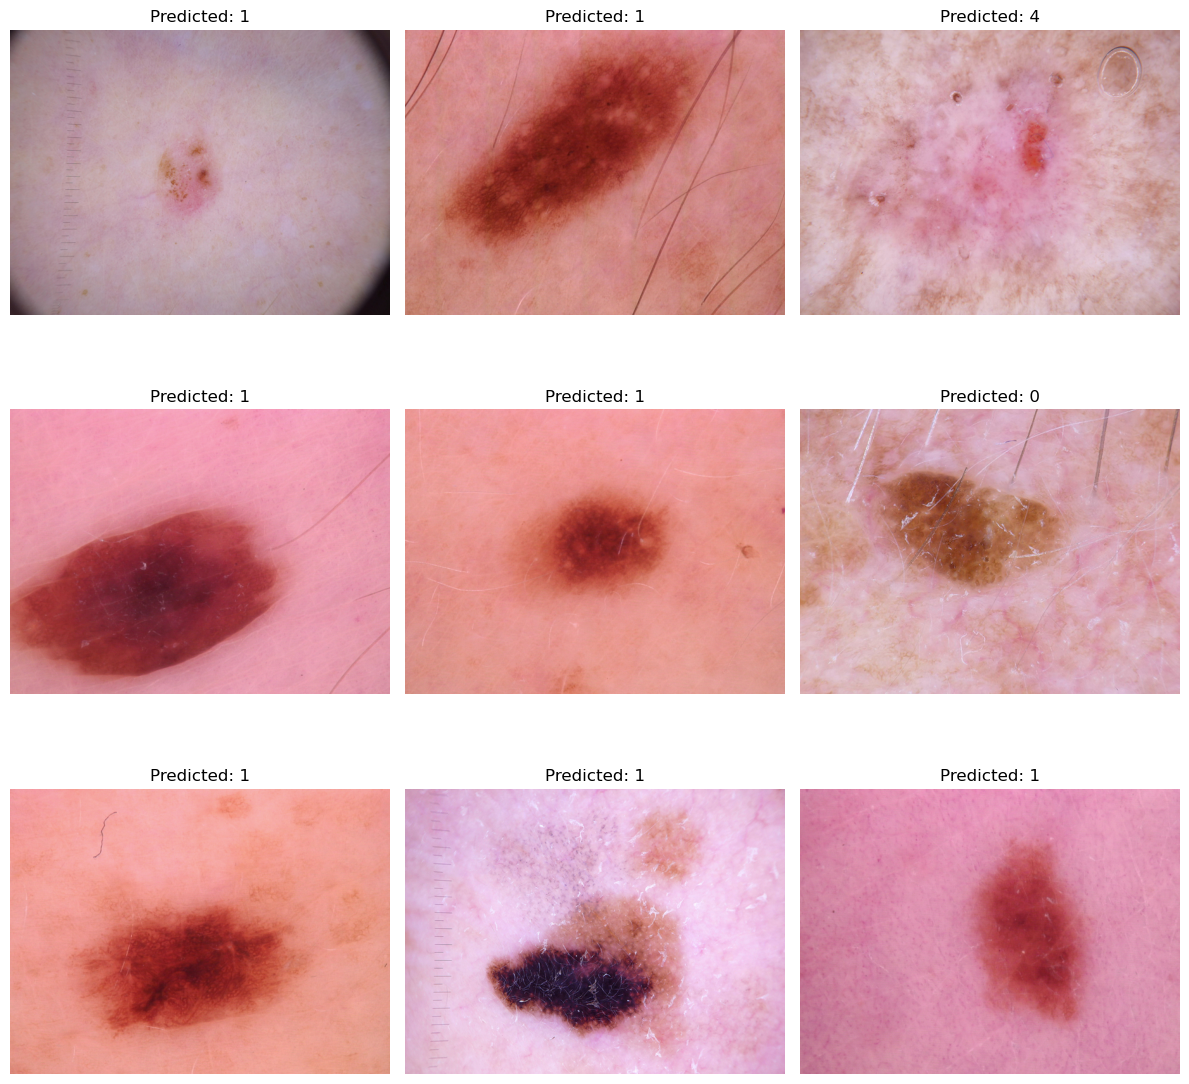

In [29]:
# show the predicted labels on some random images from the test set
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image

# Display the first few images from the test set with their predicted labels
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    # Load the image
    img = Image.open(test_metadata['image_path'][i])
    ax.imshow(img)
    
    # Set the title to the predicted class label
    ax.set_title(f'Predicted: {predicted_labels[i]}')
    ax.axis('off')
    
plt.tight_layout()
plt.show()


In [ ]:
# report of the classification for Readme
from sklearn.metrics import classification_report
# the classification report (precision, recall, f1-score)  for each class

print(classification_report(test_metadata['label'], predicted_labels))